In [64]:
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
import pandas as pd
import numpy as np

data_folder = "./data/"

#Get and load data
# pitch_14_17_file = "pitcher_2014_2017.csv"
bball_data_2_file = "Baseball Data-2.csv"

In [65]:
#preprocessing function used to calculate the plate location and isStrike classifier (this will be different than PitchCall (even in terms of BallCalled vs StrikeCalled))
#returns tuple: classification, isStrike
#classification: heart (strike) = 0, shadow (strike) = 1, shadow (ball) = 2, chase (ball) = 3, waste (ball) = 4
def PlateZone(PlateLocHeight, PlateLocSide):

    foot = 12

    #waste outside 84in to 6in, -20in to 20in horizontal, (strike zone * 200%)
    if ((PlateLocHeight > 7 or PlateLocHeight < 0.5) and (PlateLocSide < -(20/foot) or PlateLocSide > (20/foot))):
        return 4

    #heart inside 38in to 22in vertical, -6.7in to 6.7in horizontal, (strike zone size * 67%)
    if ((PlateLocHeight < (38/foot) and PlateLocHeight > (22/foot)) and (PlateLocSide > (-6.7/foot) and PlateLocSide < (6.7/foot))):
        return 0

    #strike zone inside 42in to 18in vertical, -10in to 10in horizontal
    if (PlateLocHeight < (42/foot) and PlateLocHeight > (18/foot) and (PlateLocSide > (-10/foot) and PlateLocSide < (10/foot))):
        return 1

    #shadow inside 46in to 14in vertical, -13.3in to 13.3in horizontal, (strike zone size * 133%)
    if (PlateLocHeight < (46/foot) and PlateLocHeight > (14/foot) and (PlateLocSide > (-13.3/foot) and PlateLocSide < (13.3/foot))):
        return 2

    #chase inside 84in to 6in, -20in to 20in horizontal, (strike zone * 200%)
    return 3

    #preprocessing function used to generate a single number that will be used to classify the ball/strike count before the current pitch 
    #returns int [0 - 11]
def PitchCount(balls, strikes):
    # Strikes: 0  1   2
    # Balls v|---------- 
    #       0| 0  1   2 
    #       1| 3  4   5
    #       2| 6  7   8
    #       3| 9  10  11
    if(balls == 0):
        if(strikes == 0):
            return 0
        if (strikes == 1):
            return 1
        return 2
    if(balls == 1):
        if(strikes == 0):
            return 3
        if (strikes == 1):
            return 4
        return 5
    if(balls == 2):
        if(strikes == 0):
            return 6
        if (strikes == 1):
            return 7
        return 8
    if(balls == 3):
        if(strikes == 0):
            return 9
        if (strikes == 1):
            return 10
        return 11

    #this preprocessing function generates the ground truth hitability of a pitch
    #these values will definitely need to be adjusted and should probably be hyperparameters
def GenerateGroundTruthLabels(pitchCall):
    if pitchCall == 'BallCalled':
        return -1
    if pitchCall == 'BallIntentional' or pitchCall == 'HitByPitch':
        return 0
    if pitchCall == 'StrikeSwinging' or pitchCall == 'StrikeCalled':
        return 1
    else:
        return 2


In [66]:
#import the columns we will need for training and preprocessing
bball_data = pd.read_csv(data_folder+bball_data_2_file, usecols=['Pitcher', 'PitcherThrows', 'Batter', 'BatterSide', 'PitchCall', 'KorBB', 'PlayResult', 'RunsScored', 'VertBreak', 'HorzBreak', 'ZoneSpeed', 'VertApprAngle', 'HorzApprAngle', 'ZoneTime', 'PlateLocHeight', 'PlateLocSide', 'Balls', 'Strikes', 'TaggedPitchType'])
#run preprocessing functions
bball_data['Zone'] = bball_data.apply(lambda pitch : PlateZone(pitch['PlateLocHeight'], pitch['PlateLocSide']), axis=1)
bball_data['BallStrikeNum'] = bball_data.apply(lambda pitch : PitchCount(pitch['Balls'], pitch['Strikes']), axis=1)
bball_data['GroundTruth'] = bball_data.apply(lambda pitch : GenerateGroundTruthLabels(pitch['PitchCall']), axis=1)

#normalize data

#drop all features we no longer need (ones only used for preprocessing)
bball_data.drop(labels=['PlateLocHeight', 'PlateLocSide', 'Balls', 'Strikes'], axis=1)


categorical_columns = ['Pitcher', 'Batter', 'PitchCall', 'KorBB', 'PlayResult', 'Zone', 'BallStrikeNum']
# ohe_bball_data = OneHotEncoder(sparse=False)

for category in categorical_columns:
    bball_data[category] = bball_data[category].astype('category')
    # ohe_bball_data.fit_transform(bball_data[[category]])

#Remove NaN valued rows
bball_data.dropna(inplace=True)
bball_data.reset_index(drop=True, inplace=True)

#print the labels of the features we will use to train our network
print(bball_data.keys())
print(bball_data[bball_data.isna().any(axis=1)])
# print(ohe_bball_data.categories_)

#splitting data into training, validation, testing
total_samples = len(bball_data.index)
training_samples = math.floor(0.6*total_samples)
validation_samples = math.ceil(0.2*total_samples)
testing_samples = math.ceil(0.2*total_samples)

sum = training_samples+testing_samples+validation_samples

print("total samples:",total_samples,
        "\ntraining samples:",training_samples,
        "\nvalidation samples:",validation_samples,
        "\ntesting samples:",testing_samples,
        "\nsum of training, validation, and test samples:",sum)

#makes shuffled version of the data
indices = np.arange(total_samples)
np.random.shuffle(indices) #TODO get ground truth for data sets using these indices
shuffled_bball_data = bball_data.reindex(indices).reset_index(drop=True)
#gets the amount of random data points as determined by set proportion
training_data = shuffled_bball_data.iloc[0:training_samples]
validation_data = shuffled_bball_data.iloc[training_samples:training_samples+validation_samples]
testing_data = shuffled_bball_data.iloc[training_samples+validation_samples:training_samples+validation_samples+testing_samples]

training_data

Index(['Pitcher', 'PitcherThrows', 'Batter', 'BatterSide', 'Balls', 'Strikes',
       'TaggedPitchType', 'PitchCall', 'KorBB', 'PlayResult', 'RunsScored',
       'VertBreak', 'HorzBreak', 'PlateLocHeight', 'PlateLocSide', 'ZoneSpeed',
       'VertApprAngle', 'HorzApprAngle', 'ZoneTime', 'Zone', 'BallStrikeNum',
       'GroundTruth'],
      dtype='object')
Empty DataFrame
Columns: [Pitcher, PitcherThrows, Batter, BatterSide, Balls, Strikes, TaggedPitchType, PitchCall, KorBB, PlayResult, RunsScored, VertBreak, HorzBreak, PlateLocHeight, PlateLocSide, ZoneSpeed, VertApprAngle, HorzApprAngle, ZoneTime, Zone, BallStrikeNum, GroundTruth]
Index: []

[0 rows x 22 columns]
total samples: 1028082 
training samples: 616849 
validation samples: 205617 
testing samples: 205617 
sum of training, validation, and test samples: 1028083


,Pitcher,PitcherThrows,Batter,BatterSide,Balls,Strikes,TaggedPitchType,PitchCall,KorBB,PlayResult,...,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,Zone,BallStrikeNum,GroundTruth
0,"Smith, Reed",Right,"Wimmer, Braylen",Right,0.0,0.0,Fastball,BallCalled,Undefined,Undefined,...,7.152971,3.145796,-1.361873,82.219953,-4.396842,-2.228127,0.416893,3,0.0,1
1,"Kirian, Michael",Left,"Malloy, Justyn-Henry",Right,1.0,2.0,Curveball,InPlay,Undefined,Out,...,0.028345,1.403792,0.109658,74.171713,-9.710650,2.528213,0.477986,2,5.0,2
2,"Haire, Rian",Left,"Francisco, Thomas",Left,0.0,2.0,Fastball,InPlay,Undefined,Single,...,-5.655542,3.547709,-0.601440,76.748067,-4.909862,0.475112,0.448126,2,2.0,2
3,"Downey, Austin",Right,"Bliss, Ryan",Right,3.0,2.0,Fastball,BallCalled,Walk,Undefined,...,5.551220,1.607190,0.547210,79.829760,-6.573828,-0.271084,0.427790,1,11.0,1
4,"Fricke, Zach",Right,"Zimmerman, Brooks",Right,2.0,0.0,Undefined,FoulBall,Undefined,Undefined,...,5.444120,1.986049,-0.503107,78.933642,-6.793470,-2.306263,0.430422,0,6.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616844,"Detmers, Reid",Left,"Guldberg, Michael",Right,0.0,2.0,Fastball,StrikeCalled,Strikeout,Undefined,...,-8.910826,2.754469,0.932048,80.759413,-5.420903,0.892067,0.429034,2,2.0,-1
616845,"Hill, Kyle",Right,"Shepherd, Connor",Left,0.0,1.0,Fastball,BallCalled,Undefined,Undefined,...,-7.665652,4.754382,0.192250,81.854440,-2.719711,-0.855474,0.420453,3,1.0,1
616846,"Carey, Jack",Right,"Wilkerson, Colby",Left,0.0,1.0,Undefined,InPlay,Undefined,Single,...,12.202960,2.831199,0.040832,85.294110,-4.786798,-1.749428,0.407451,0,1.0,2
616847,"Webb, Ryan",Left,"Milone, Brennan",Right,2.0,1.0,Fastball,InPlay,Undefined,Single,...,-14.539079,2.119139,-1.181651,81.513128,-6.098199,-0.362211,0.425968,3,7.0,2


In [93]:
from sklearn import metrics
#scikit learn doesnt support categorical columns
non_training_cols = [*categorical_columns,'PitcherThrows','BatterSide','TaggedPitchType','GroundTruth']
X = training_data.loc[:,~training_data.columns.isin(non_training_cols)]
y = training_data.loc[:,training_data.columns == 'GroundTruth']

vX = validation_data.loc[:,~validation_data.columns.isin(non_training_cols)]
vy = validation_data.loc[:,validation_data.columns == 'GroundTruth']

# decision_tree = tree.DecisionTreeClassifier(min_samples_leaf=10000,max_depth=10)

possible_min_leaf_samples = [1,1000,5000,10000,20000,30000,50000,100000,200000]
possible_depths = [1,2,5,10,20,30,50,100,200]

#validation (hyper-parameter tuning)
parameter_accuracy = []
for msl in possible_min_leaf_samples:
    for d in possible_depths:
        #train on training with this iteration of parameters
        decision_tree = tree.DecisionTreeClassifier(min_samples_leaf=msl, max_depth=d)
        decision_tree = decision_tree.fit(X, y)
        #then check accuracy of validation data
        val_pred = decision_tree.predict(vX)
        score = metrics.accuracy_score(vy,val_pred)
        #put parameters and accuracy in matrix
        parameter_accuracy.append((msl,d,score))
        print(msl,d,score)

#select parameters with highest accuracy
parameter_accuracy.sort(key = lambda x:x[2])

best_parameters = parameter_accuracy[-1]
print(best_parameters)


decision_tree = tree.DecisionTreeClassifier(min_samples_leaf=best_parameters[0], max_depth=best_parameters[1])
decision_tree = decision_tree.fit(X, y)
test_input = testing_data.loc[:,~testing_data.columns.isin(non_training_cols)]
test_ground_truth = testing_data.loc[:,testing_data.columns == 'GroundTruth']

res_pred = decision_tree.predict(test_input)
score = metrics.accuracy_score(test_ground_truth,res_pred)
print(score*100)

1 1 0.4397836754743042
1 2 0.5157647470783058
1 5 0.627579431661779
1 10 0.6497760399188783
1 20 0.6332307153591386
1 30 0.5924121060029083
1 50 0.5787313305806426
1 100 0.5781817651264244
1 200 0.5783568479259983
1000 1 0.4397836754743042
1000 2 0.5157647470783058
1000 5 0.627579431661779
1000 10 0.6495182791306167
1000 20 0.6622604162107218
1000 30 0.6622604162107218
1000 50 0.6622604162107218
1000 100 0.6622604162107218
1000 200 0.6622604162107218
5000 1 0.4397836754743042
5000 2 0.5157647470783058
5000 5 0.627579431661779
5000 10 0.645695638006585
5000 20 0.6532193349771663
5000 30 0.6532193349771663
5000 50 0.6532193349771663
5000 100 0.6532193349771663
5000 200 0.6532193349771663
10000 1 0.4397836754743042
10000 2 0.5157647470783058
10000 5 0.627579431661779
10000 10 0.6361341717854069
10000 20 0.6383810677132727
10000 30 0.6383810677132727
10000 50 0.6383810677132727
10000 100 0.6383810677132727
10000 200 0.6383810677132727
20000 1 0.4397836754743042
20000 2 0.5157647470783058
2

951


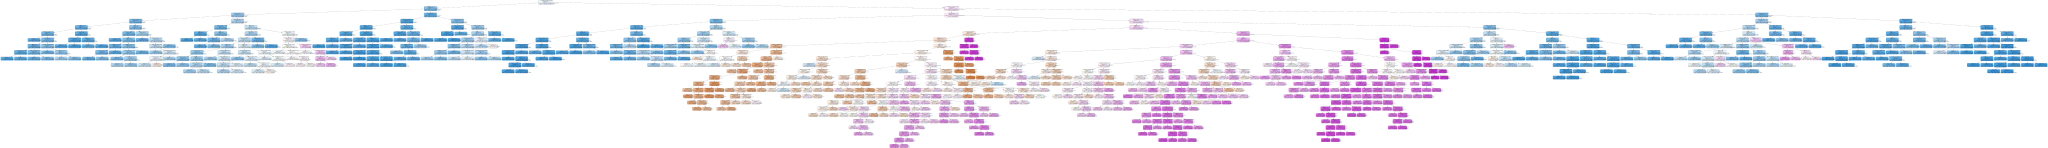

In [95]:
#use graphviz to make pdf and image of tree
import graphviz

# dot_data = tree.export_graphviz(decision_tree,out_file=None)
# graph = graphviz.Source(dot_data)
# graph.render("bball_basic_decision_tree")
print(decision_tree.tree_.node_count)

feature_labels = X.keys()
class_labels = ['BallCalled','BallIntentional/HitByPitch','StrikeSwinging/StrikeCalled',"Correct Swing"]

#tree with recognizable labels and color coded nodes corresponding to classes
dot_data = tree.export_graphviz(decision_tree, out_file=None,
                                feature_names = feature_labels,
                                class_names = class_labels,
                                filled=True, rounded = True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("bball_basic_decision_tree_labeled")
graph 